<a href="https://colab.research.google.com/github/17kaMIKAze08/machinelearning_UNIL/blob/main/Labs/S3_2_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering

photo-1542739674-b449a8938b59.avif

<img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EYCb6vvFoSlMoAfr_YXSg8UBoMRAF1cpIUTeUFFhBVYsZw?download=1'>
<center> Photo Credits: <a href='https://unsplash.com/photos/PizD8punZsw'>Three Assorted-Color Garbage Cans</a> by <a href='https://unsplash.com/@julytheseventifirst'>Hamza Javaid</a> licensed under the <a href='https://unsplash.com/license'>Unsplash License</a>
</center>

*Sorting takes a lot of effort - is there a way that we can get computers to do it automatically for us when we don't even know where to begin?*

This notebook will be used in the lab session for week 4 of the course, covers Chapters 9 of Géron, and builds on the [notebooks made available on _Github_](https://github.com/ageron/handson-ml2).

Need a reminder of last week's labs? Click [_here_](https://colab.research.google.com/github/tbeucler/2022_ML_Earth_Env_Sci/blob/main/Lab_Notebooks/Week_3_Decision_Trees_Random_Forests_SVMs.ipynb) to go to notebook for week 3 of the course.

**Notebook Setup**

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
rnd_seed = 2022
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

**Data Setup**

We need to load the MNIST dataset from OpenML - we won't be loading it as a Pandas dataframe, but will instead use the Dictionary / ndrray representation.

In [3]:
#Load the mnist dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist['data']
y = mnist['target'].astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


We're going to subsample the digits in the dataset, choosing a random set of digit classes - we won't even know the number of different digits we will chose; it will be somewhere between 4 and 8!

In [4]:
# Generating the random set of digit labels we will use to extract samples from
# the MNIST handwritten digit dataset.

digits = rnd_gen.choice(np.arange(10), # Digit Possibilities
                        int( np.round( rnd_gen.uniform(3.5, 8.5) ) ), # Number of digits to use
                        replace = False) # Can't repeat digits

We will learn on a total of 8000 digits, evenly distributed amongst the randomly selected digits in the dataset. Let's store the number of samples to be taken from each class.

In [5]:
# Let's find a round number of digits to extract for each digit
num_samples = np.round(8000/len(digits) + 1 ).astype(int)

With that out of the way, let's generate the dataset!

In [6]:
# Placeholder Vars
sub_X = None
sub_y = None

# Looping through digit types
for digit in digits:
  # find indices where target is digit of interest
  y_idxs = y==digit

  # rnd_gen.choice chooses n = balanced_size indices from the set of digits
  # available. Since we know the truth is an array with the same number of rows
  # as the subset, full of the current digit
  X_subset = X[y_idxs][rnd_gen.choice(np.arange(y_idxs.sum()),(num_samples,))]
  y_subset = np.full(X_subset.shape[0],digit)

  if type(sub_X) == type(None):
    sub_X = X_subset
    sub_y = y_subset
  else:
    sub_X = np.vstack([sub_X, X_subset])
    sub_y = np.hstack((sub_y,y_subset))

# Shuffling the dataset, also limitting the number of digits to 8000 so we can't
# cheat and tell how many digits there are by looking at the length of the array
shuffler = rnd_gen.permutation(len(sub_X))
sub_X = sub_X[shuffler][:8000]
sub_y = sub_y[shuffler][:8000]

We now have a set of 8000 random samples that we know belong to somewhere between 4 and 8 clusters 😃 <br> Can we divide them into these groups without knowing the labels beforehand?

**Warning**: Don't expect near perfect results this time.

Clustering with KMeans

The first thing we need to do is to import the KMeans model from scikit learn. Let's go ahead and do so.

## Q1) Import the KMeans model from scikit learn.

*Hint: [Here is the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) for the Kmeans implementation in sklearn.*

In [8]:
# Import KMeans class from scikit-learn here
from sklearn.cluster import KMeans

We don't know how many clusters we should use to split the data. Our first instinct would be to use as many clusters as the number of digits we have, but even that is not necessarily optimal. Why dont we try all K's between 4 and 40?

To do so, we'll need to begin by training a Kmeans algorithm for each value of K we're interested in.


How long does it take to train a single KMeans model with 10 initial centroid settings? This will give us an idea as to whether it may be a good idea to apply a dimensionality reduction algorithm before fitting our models.

## Q2) Import python's `time` library and measure how long it takes to train a single KMeans model with 3 clusters on the raw data subset.

*Hint 1: [Here is the documetation](https://docs.python.org/3/library/time.html#time.time) for the function used to get timestamps*

In [9]:
# ---------------------------------------------------------------------------------------------------------------
# Import time to time our training process
# ---------------------------------------------------------------------------------------------------------------
import time

# ---------------------------------------------------------------------------------------------------------------
# Here we will time the KMeans algorithm very similar to what we did for the first notebook.
# ---------------------------------------------------------------------------------------------------------------
t0 = time.time()

# --------------------------------------------------------------------------------------------------------------------
# We will now train the KMeans model with 3 clusters and rnd_seed for random_state. Time the training process as well.
# --------------------------------------------------------------------------------------------------------------------
kmeans_test = KMeans(n_clusters=3, # Number of clusters to split into
                     random_state = rnd_seed) # Random seed
kmeans_test.fit(sub_X) # Fitting to data subset
t1 = time.time()

print(f"Training took {(t1 - t0):.2f}s")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training took 7.87s


This should seem like a bit longer than we want. (3.42 seconds during testing of the notebook). Doing this many times means there's a possibility we'll be sitting around doing *nothing*, possiblity for *several minutes*. ***Who has time for this?***

Let's reduce the dataset using PCA, capturing 95% of the variability in the data.

## Q3) Import PCA from scikit and reduce the dimensionality of our input data. 95% of the variance in the data should be captured.

*Hint 1: [Here is the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for PCA.*

*Hint 2: `.fit_transform()` will be very useful*

In [10]:
# --------------------------------------------------------------------------------------------------------------------
# Import PCA class
# --------------------------------------------------------------------------------------------------------------------
from sklearn.decomposition import PCA

# --------------------------------------------------------------------------------------------------------------------
# Instantiate PCA, only retain enough components for 95% of variance in data
# --------------------------------------------------------------------------------------------------------------------
pca = PCA(n_components=.95)

In [11]:
# --------------------------------------------------------------------------------------------------------------------
# Fit model and transform the sub_X datast
# --------------------------------------------------------------------------------------------------------------------
reduced_X = pca.fit_transform(sub_X)

Let's try training a KMeans model on the reduced dataset and see if our training time improved...

## Q5) Repeat Q2 using the reduced dataset
*Reminder: We're still splitting the data into 3 clusters*

In [13]:
# --------------------------------------------------------------------------------------------------------------------
# We will now train the KMeans model with 3 clusters and rnd_seed for random_state. Time the training process as well.
# The kmeans algorithm should now fit to the reduced_X subset
# --------------------------------------------------------------------------------------------------------------------
t0 = time.time()
kmeans_test = KMeans(n_clusters=3, # Number of clusters to split into
                     random_state = rnd_seed) # Random seed
kmeans_test.fit(reduced_X) # Fitting to reduced data subset
t1 = time.time()

print(f"Training took {(t1 - t0):.2f}s")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training took 2.99s


## Q6) Train a KMeans model for $\; 2 \le k \le 20$

*Hint 1: Set up a range using python's [`range`](https://docs.python.org/3/library/functions.html#func-range) function or numpy's [`arange`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)*

*Hint 2: You can store each trained model by appending it to a list as you iterate*

In [19]:
# --------------------------------------------------------------------------------------------------------------------
# Create a list of numbers from 2 to 20 with the range() function
# --------------------------------------------------------------------------------------------------------------------
import numpy
k_list = numpy.arange(2, 21, 1, dtype=int)
print(k_list)

# --------------------------------------------------------------------------------------------------------------------
# Create an empty list to store the fitted models with different k values
# --------------------------------------------------------------------------------------------------------------------
kmeans_models = list()

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [21]:
# -----------------------------------------------------------------------------------------------------------------------------------
# Use a for loop to train and store different kmeans models. What you fill in here should be similar to what you just did from Q1-Q5.
# ------------------------------------------------------------------------------------------------------------------------------------
t0 = time.time() # Get a timestamp to keep track of time
for k in k_list:
    #print out a statement stating which k value you are working on
    t1 = time.time() # Get a current timestamp
    print(f"\r Currently working on k={k}, elapsed time: {(t1 - t0):.2f}s", end="")

    kmeans = KMeans(n_clusters=k, # Set the number of clusters
                      random_state= rnd_seed ) # Set the random state
    kmeans.fit(sub_X) # Fit the model to the reduced data subset

    kmeans_models.append(kmeans) # store the model trained to predict  k clusters

# -----------------------------------------------------------------------------------------------------------------------------------
# We spent around 56.5s to train the models
# ------------------------------------------------------------------------------------------------------------------------------------
print(f"\r Finished training the models! It took: {(time.time() - t0):.2f}s")

 Currently working on k=2, elapsed time: 0.01s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=3, elapsed time: 9.29s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=4, elapsed time: 14.17s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=5, elapsed time: 20.74s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=6, elapsed time: 28.78s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=7, elapsed time: 38.62s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=8, elapsed time: 48.54s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=9, elapsed time: 58.97s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=10, elapsed time: 72.70s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=11, elapsed time: 84.66s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=12, elapsed time: 97.54s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=13, elapsed time: 109.33s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=14, elapsed time: 124.82s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=15, elapsed time: 138.29s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=16, elapsed time: 152.42s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=17, elapsed time: 164.95s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=18, elapsed time: 178.11s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=19, elapsed time: 193.06s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Currently working on k=20, elapsed time: 210.74s

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Finished training the models! It took: 227.82s


You should hopefully remember the silhouette score and inertia metrics from the reading. Let's go ahead and make a $k$ vs $silhouette$ plot and a $k$ vs $inertia$ plot.

## Q7) Import the silhouette score metric and generate a silhouette score value for each model we trained

*Hint 1: [Here is the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for the Silhouette score implementation in scikit learn*

*Hint 2: The silhouette score needs the model input data and the model labels as arguments*

*Hint 3: The model labels are stored as an attribute in each model. Check the list of available attributes in the [sklearn KMeans documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).*

In [23]:
# --------------------------------------------------------------------------------------------------------------------
# Import silhouette_scores metric
# --------------------------------------------------------------------------------------------------------------------
from sklearn.metrics import silhouette_score

In [24]:
# --------------------------------------------------------------------------------------------------------------------
# Use list comprehension to store the silhouette score for all trained models (check the documentaion if you need help
# setting up in arguments as specified in Hint 2 and 3)
# --------------------------------------------------------------------------------------------------------------------
silhouette_scores = [silhouette_score(sub_X, model.labels_)
                     for model in kmeans_models]

## Q8) Plot comparing $k$ vs Silhouette Score. Highlight the maximum score

*Hint 1: You'll need to find the position of the best score in the silhouette score list. [Here is the documentation ](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)to a numpy function that would be very useful for this.*

*Hint 2: matplotlib's pyplot has been imported as `plt`. [Here is the documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.subplots.html) to the `subplots()` method.*

*Hint 3: [Here is the documentation](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html) to the `plot()` method in matplotlib's pyplot. Note that it is also implemented as a method in the `axes` objects created with `plt.subplots()`*


In [25]:
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Find the index of model with the highest score. We recommend converting the silhouette_scores list to numpy array to use the function in Hint 1
# --------------------------------------------------------------------------------------------------------------------------------------------------
best_index = numpy.argmax(numpy.array(silhouette_scores))

In [26]:
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Find out which k value the 'best_index' that you just got corresponds to.
# --------------------------------------------------------------------------------------------------------------------------------------------------
best_k = kmeans_models[best_index] # Get the best K value, per the silhouette score

# --------------------------------------------------------------------------------------------------------------------------------------------------
# Store the silhouette score corresponds to 'best_index' here.
# --------------------------------------------------------------------------------------------------------------------------------------------------
best_score = silhouette_scores[best_index]

In [28]:
best_k

KMeans(n_clusters=2, random_state=2022)

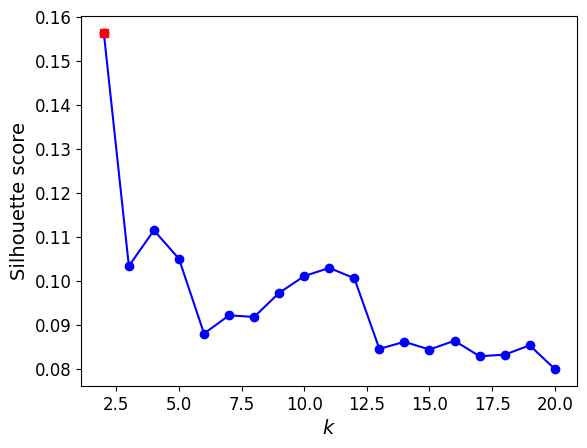

In [29]:
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Create a k-silhouette score diagram (horizontal axis: K values, vertical axis: silhouette score)
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Make a figure with size (12,4)
fig, ax = plt.subplots()

ax.plot(k_list, silhouette_scores, "bo-")

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Silhouette score", fontsize=14)

ax.plot(best_k.n_clusters, best_score, "rs")
plt.show()

We got this figure when we ran the code. Does your figure look the same?

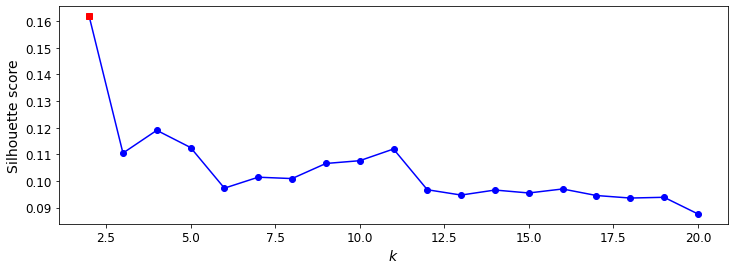

Now we'll plot the value of $k$ vs inertia

## Q9) Plot comparing $k$ vs Inertia. Highlight the inertia for the model with the highest silhouette score

*Hint 1: If you followed the previous step as it was written, you have the index for the best model stored in*`best_index`.

*Hint 2: [The KMeans documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) details the attribute in which the model's intertia is stored.*


In [31]:
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Iterate through the list of kmeans models and store the model inertias
# --------------------------------------------------------------------------------------------------------------------------------------------------
inertias = [model.inertia_ for model in kmeans_models]

# --------------------------------------------------------------------------------------------------------------------------------------------------
# Get the inertia for the model with the highest silhouette score
# --------------------------------------------------------------------------------------------------------------------------------------------------
best_inertia = inertias[best_index]

TypeError: ignored

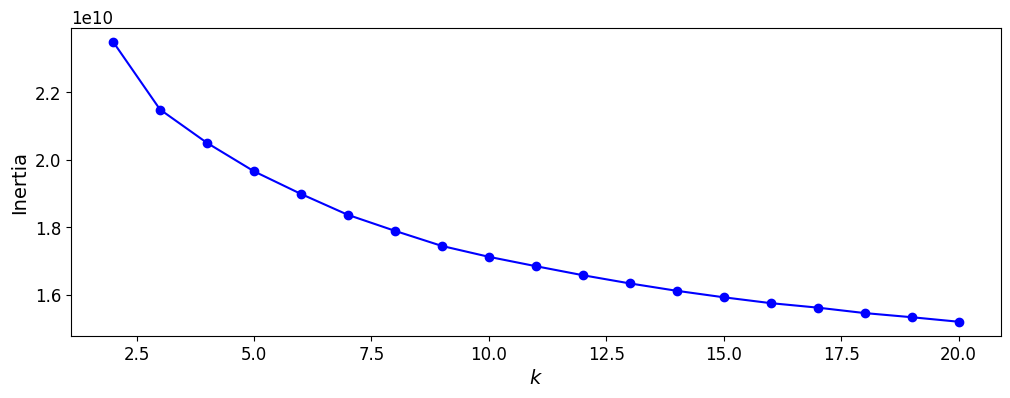

In [34]:
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Create a k-silhouette score diagram (horizontal axis: K values, vertical axis: inertia)
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Make a figure with size (12,4)
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(k_list, inertias, "bo-")

ax.set_xlabel("$k$", fontsize=14)
ax.set_ylabel("Inertia", fontsize=14)

ax.plot(best_k, best_inertia, "rs")

You should see a figure similar to the one below.

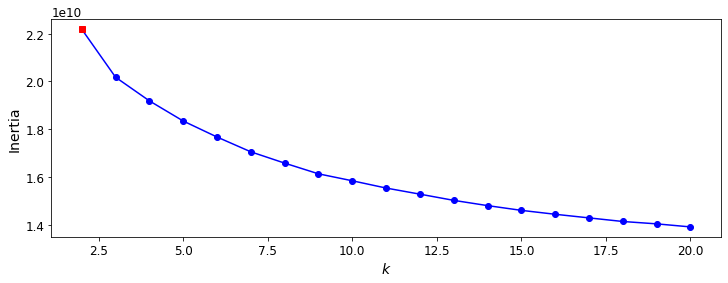

If you ran the notebook with the default random seed, you may be surprised to see that the best performing KMeans model is the one that breaks it off into two clusters! The next best two will be those associated with $k=4$ and $k=5$. Let's get some plots to try to make sense of the results, since we have the actual labels.

There aren't any more questions to answer from here on out, but you *will* have to change the code if you started out from a different random seed! I'll try to be good about pointing out what code you'll need to change.

Let's begin by using [scikit's TSNE implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the dimensionality of the dataset for plotting. This will take a bit of computation time!

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, # We'll project onto 2D plane
            random_state=rnd_seed, # We need a random seed
            learning_rate='auto') #Let the algorithm handle the learning rate

# And now get the input data in 2-component reduced form
X_plot = tsne.fit_transform(sub_X)

Let's continue by making a list of the three best models.

In [37]:
# --------------------------------------------------------------------------------------------------------------------------------------------------
# Make an empty list to store the three best models
# --------------------------------------------------------------------------------------------------------------------------------------------------
best_models = []

# --------------------------------------------------------------------------------------------------------------------------------------------------
# Use the best_index to get the best model
# --------------------------------------------------------------------------------------------------------------------------------------------------
best_models.append(kmeans_models[best_index])

# --------------------------------------------------------------------------------------------------------------------------------------------------
# Manually retrieve 2nd and 3rd best models
# First use np.argsort() to sort all silhouette scores. The second to last and third to last indices correspond to the second and third best models.
# --------------------------------------------------------------------------------------------------------------------------------------------------second_index,third_index = np.asarray(silhouette_scores).argsort()[-2],np.asarray(silhouette_scores).argsort()[-3]
second_index,third_index = np.asarray(silhouette_scores).argsort()[-2],np.asarray(silhouette_scores).argsort()[-3]
best_models.append(kmeans_models[second_index])
best_models.append(kmeans_models[third_index])

And now, let's get a set of predictions for each model and store it in a list!

In [39]:
pred_labels = []
for model in best_models:
    pred_labels.append(model.predict(sub_X))

Pandas will make producing a nice plot a lot simpler. Let's import it and make a dataframe with the reduced input components, the truth labels, and the predicted cluster labels.

Note that the predicted labels don't correspond to the digit labels since this is an unsupervised model!

In [40]:
import pandas as pd

plot_data = np.stack([X_plot[:,0], X_plot[:,1], sub_y, *pred_labels],axis=1)
df = pd.DataFrame(plot_data, columns=['X1','X2','truth','pred_1','pred_2','pred_3'])

And now we'll make a nice, big 4x4 plot that allows us to see the true answers and how our algorithm clustered our data!

(-99.12883758544922, 109.05475616455078, -83.47379570007324, 89.58709983825683)

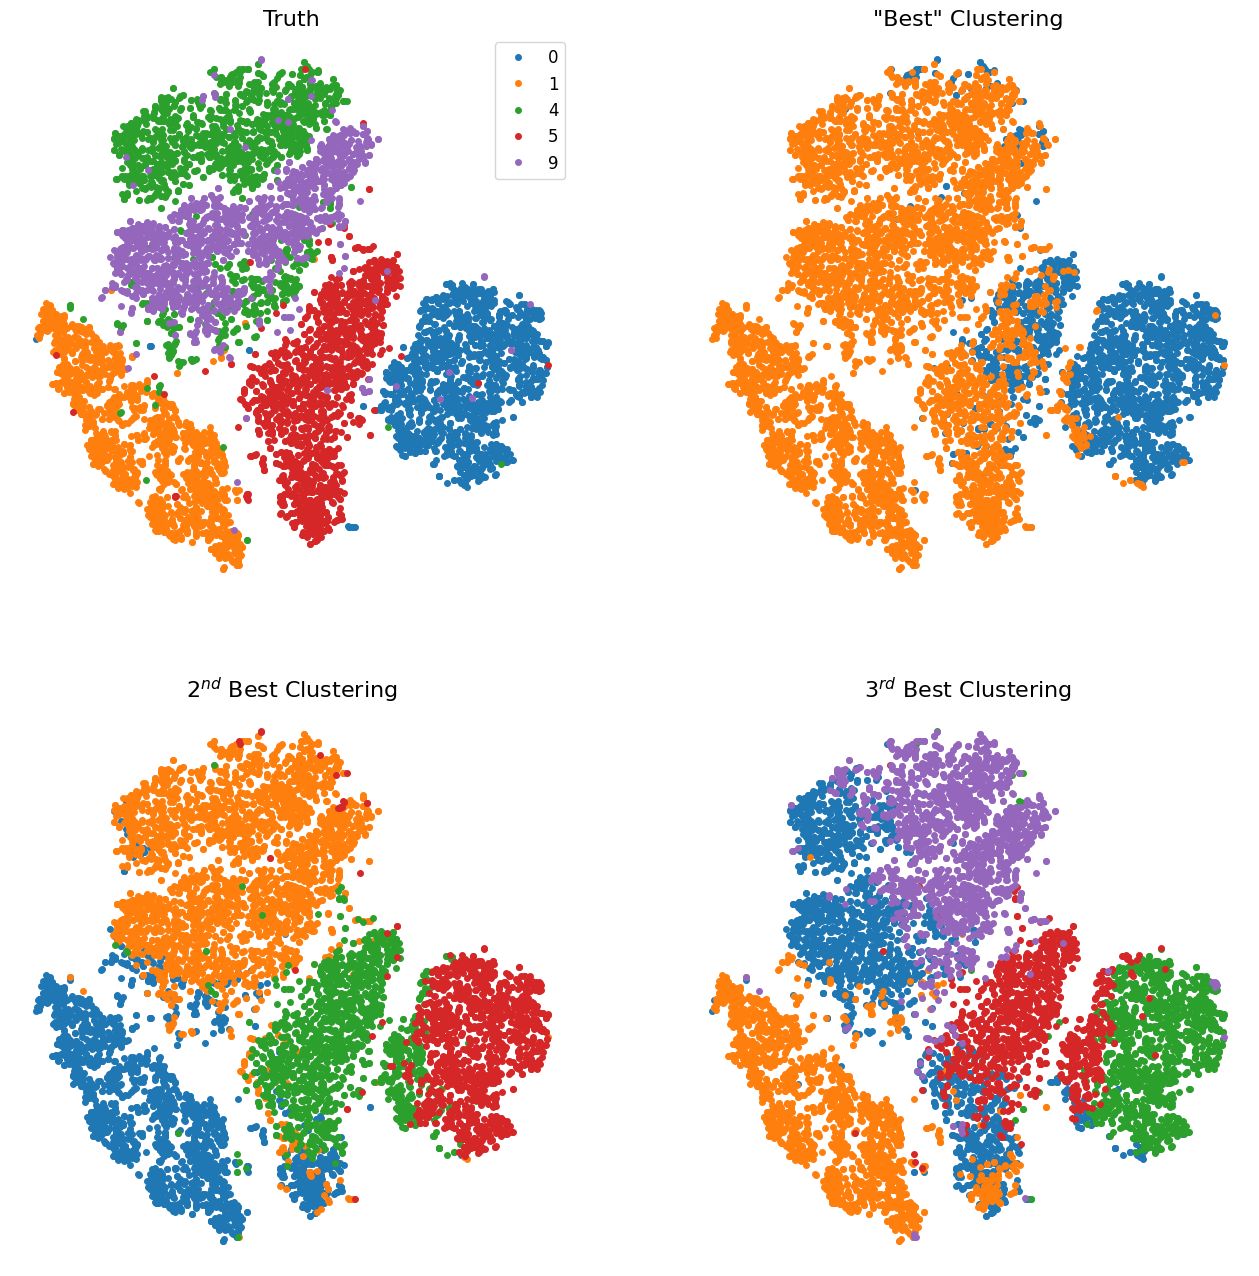

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16,16))

groups = df.groupby('truth')
for label, group in groups:
    axes[0,0].plot(group.X1, group.X2, marker='o', linestyle='', markersize=4, label=int(label))
axes[0,0].legend(fontsize=12)
axes[0,0].set_title('Truth', fontsize=16)
axes[0,0].axis('off')

groups = df.groupby('pred_1')
for label, group in groups:
    axes[0,1].plot(group.X1, group.X2, marker='o', linestyle='', markersize=4)
axes[0,1].set_title('"Best" Clustering', fontsize=16)
axes[0,1].axis('off')

groups = df.groupby('pred_2')
for label, group in groups:
    axes[1,0].plot(group.X1, group.X2, marker='o', linestyle='', markersize=4)
axes[1,0].set_title('$2^{nd}$ Best Clustering', fontsize=16)
axes[1,0].axis('off')

groups = df.groupby('pred_3')
for label, group in groups:
    axes[1,1].plot(group.X1, group.X2, marker='o', linestyle='', markersize=4)
axes[1,1].set_title('$3^{rd}$ Best Clustering', fontsize=16)
axes[1,1].axis('off')

Our figure looks like this.

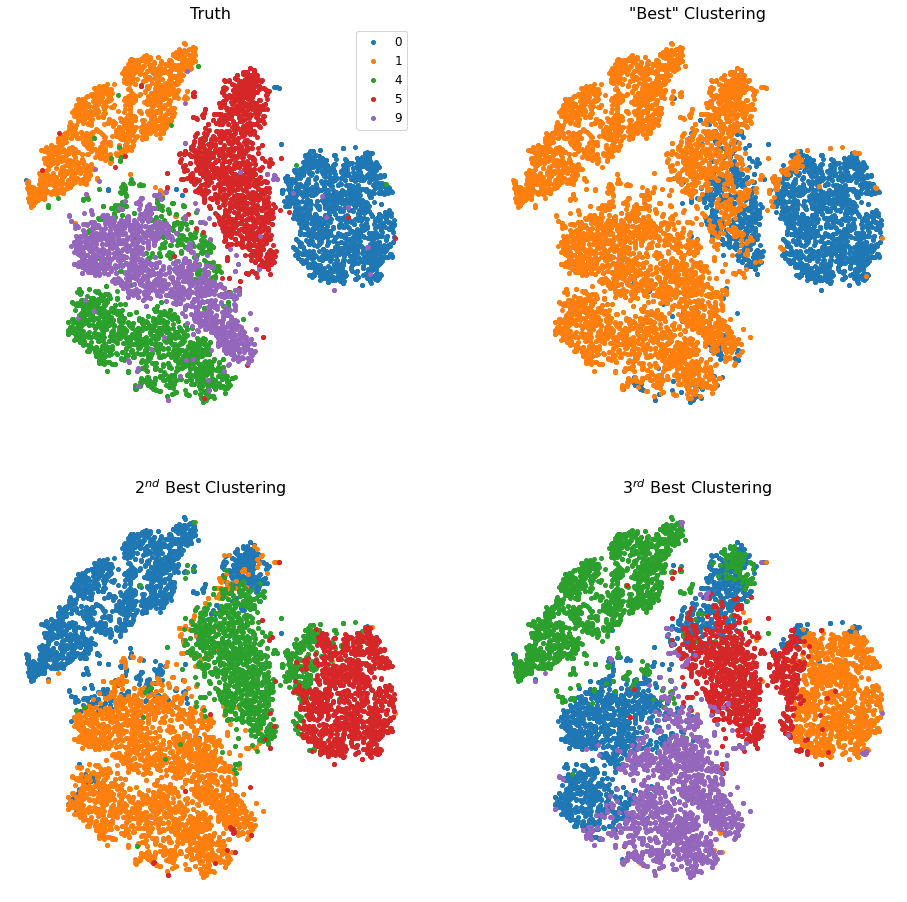

Assuming you started out from the intended random seed, you'll be able to see that the "Best" model is trying to separate the 0 digits from the non-zero digits. The $2^{nd}$ best model is able to separate the digits pretty well, but lumps 4s and 9s into a single cluster!

The $3^{rd}$ best model begins to group digits into clusters that may not have much significance to us at first glance, but whose metrics seem to indicate worse performance and whose results would need further analysis to try to understand.